In [1]:
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import jax.numpy as jnp
from jax import random
from jax.tree_util import tree_map
from scipy.io import loadmat
import time

# Go up 3 levels to the repo's root directory
repo_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))

# Add the repo root to sys.path
sys.path.append(repo_root)

from data_processing.helpers import normalize, sample
from models.initialization import init_single_net, neural_net, init_pinns, create_solution
from equations.simple_mass_conservation import gov_eqn
from models.optimization import adam_optimizer, lbfgs_optimizer

In [2]:
from scipy.io import loadmat
from scipy.io.matlab.mio5_params import mat_struct

def mat_struct_to_dict(mat_obj):
    """Recursively convert mat_struct objects to nested dictionaries."""
    data = {}
    for fieldname in mat_obj._fieldnames:
        elem = getattr(mat_obj, fieldname)
        if isinstance(elem, mat_struct):
            data[fieldname] = mat_struct_to_dict(elem)
        else:
            data[fieldname] = elem
    return data

def load_mat_file(filepath):
    """Load a .mat file and handle mat_struct conversion."""
    mat_data = loadmat(filepath, struct_as_record=False, squeeze_me=True)
    
    data_dict = {}
    for key, value in mat_data.items():
        if isinstance(value, mat_struct):
            data_dict[key] = mat_struct_to_dict(value)
        else:
            data_dict[key] = value

    return data_dict
mat = load_mat_file('../../data_processing/Process_Ronne_pRES/KFResults_gammaDx_x=15_nIter=10000.mat')
x = mat['xTrue']
z = mat['zTrue']
u = mat['uTrue'] # for comparison, and for surface bondary condition
w = mat['wTrue'] # only w is known throughout
rho = mat['RhoTrue'] # for basal boundary condition
p = rho*9.81*mat['TrueDepth']
#p = np.zeros(x.shape) # for surface boundary condition
mu = np.ones(x.shape) # dummy for now

dict_full = {}
dict_surf = {}
dict_flanks = {}
dict_bed = {}
dict_divide = {}

for key, var in zip(['x','z','u','w','rho','p','mu'],[x,z,u,w,rho,p,mu]):
    dict_full[key]=var.flatten()
    dict_surf[key]=var[:,-1]
    dict_bed[key] = var[:,0]
    dict_flanks[key] =np.array([var[0,:].flatten(),var[-1,:].flatten()]).flatten()
    div_bed = np.interp(0,x[:,0],var[:,0])
    vardiv_surf = np.interp(0,x[:,-1],var[:,-1])
    div = np.linspace(div_bed,vardiv_surf,100).reshape((100,1))
    dict_divide[key] = div.flatten()
dict_divide['u'] = np.zeros(dict_divide['x'].shape)

df_full = pd.DataFrame(dict_full)
df_surf = pd.DataFrame(dict_surf)
df_bed = pd.DataFrame(dict_bed)
df_flanks = pd.DataFrame(dict_flanks)
df_divide = pd.DataFrame(dict_divide)


/var/folders/q5/9bzlkvcx1glgh6zpxpsqsmm40000gn/T/ipykernel_6691/289519529.py:2: DeprecationWarning: Please import `mat_struct` from the `scipy.io.matlab` namespace; the `scipy.io.matlab.mio5_params` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.io.matlab.mio5_params import mat_struct
/Users/georgelu/anaconda3/envs/fenics-env-1/lib/python3.9/site-packages/scipy/io/matlab/_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [3]:
# generate PINN
# select a random seed
seed = 1234 #2134
key = random.PRNGKey(seed)
np.random.seed(seed)

# create the subkeys
keys = random.split(key, 4) # NEED TO UPDATE 4 to relevant number
n_hl = 6
n_unit = 30
# initialize the weights and biases of the network
trained_params = init_pinns(keys[0], n_hl, n_unit)

In [4]:
# normalize
df_norm,df_bcs,info = normalize(df_full, df_surf, df_divide, df_bed, df_flanks)
# df_bcs contains the data for surface, divide,bed and flanks

In [5]:
pred_u = create_solution(df_bcs[0]) # need to modify as well


In [6]:
# for adam
n_samples = jnp.array([200,200]) # small number for now
dataf = sample(df_norm,n_samples,df_bcs) # nsamples is for data loss + colocation points
keys_adam = random.split(keys[1], 5)
data = dataf(keys_adam[0])

# for L-BFGS
n_pt2 = n_samples * 2
dataf_l = sample(df_norm, n_pt2,df_bcs)
key_lbfgs = random.split(keys[2], 5)

In [7]:
def ms_error(diff):
    return jnp.mean(jnp.square(diff), axis=0)

def create_loss_masscon(predf,gov_eqn,scales,lw):
    # for now do 3 lw weights: data, eqn, bc
    def loss_fun(params, data):
        # create the function for gradient calculation involves input Z only
        net = lambda z: predf(params, z)
        
        # load the ground truth for dataloss
        x_smp = data['smp'][0]
        w_smp = data['smp'][1][:,1:2] # ground truth w
        x_div = data['div'][0]
        u_div = data['div'][1][:,0:1] # horizontal velocity at divide (should be 0)
        x_bed = data['bed'][0]
        w_bed = data['bed'][1][:,1:2] # ground truth w at bed (should be 0)
        rho_bed = data['bed'][1][:,2:3] # ground truth rho at bed (should be rho_i)
        x_surf = data['surf'][0]
        u_surf = data['surf'][1][:,0:1] # ground truth surface horizontal velocity 

        # load the position and weight of collocation points
        x_col = data['col'][0]

        # calculate the predicted variables
        w_pred = net(x_smp)[:, 1:2] # not 0:2 because we only have data in w

        # boundary constraints
        u_div_pred = net(x_div)[:,0:1]
        bed_pred = net(x_bed)
        w_bed_pred = bed_pred[:,1:2]
        rho_bed_pred = bed_pred[:,2:3]
        u_surf_pred = net(x_surf)[:,0:1]
        
        # calculate the residue of equation
        f_pred,terms = gov_eqn(net, x_col, scales)

        # calculate the mean squared root error of data
        data_err = ms_error(w_pred - w_smp)

        # calculate the mean squared root error of equation
        eqn_err = ms_error(f_pred)

        # calculate errors of boundary conditions
        div_err = ms_error(u_div_pred-u_div)
        rho_bed_err = ms_error(rho_bed-rho_bed_pred)
        w_bed_err = ms_error(w_bed-w_bed_pred)
        surf_err = ms_error(u_surf-u_surf_pred)

        # all errors should be 1d arrays
        # calculate the overall data loss and equation loss
        loss_data = jnp.sum(data_err)
        loss_eqn = jnp.sum(eqn_err)
        loss_bd = jnp.sum(div_err) + jnp.sum(rho_bed_err) + jnp.sum(w_bed_err) + jnp.sum(surf_err)

        loss_ref = loss_fun.lref
        # calculate total loss

        # lw should have 3 weights
        loss = (lw[0]*loss_data + lw[1]*loss_eqn + lw[2]*loss_bd ) / loss_ref
        
        # group the loss of all conditions and equations
        loss_info = jnp.hstack([jnp.array([loss, loss_data, loss_eqn, loss_bd]),
                                data_err, eqn_err, div_err, rho_bed_err, w_bed_err,surf_err])
        return loss, loss_info

    loss_fun.lref = 1.0
    return loss_fun

In [8]:
# create the loss function
NN_loss = create_loss_masscon(pred_u, gov_eqn, info, [1,1,1])
# calculate the initial loss and set it as the reference value for loss
NN_loss.lref = NN_loss(trained_params, data)[0]

In [9]:
# set the learning rate for Adam
lr = 1e-3
# set the training iteration
epoch1 = 10000

# training with Adam
trained_params, loss1 = adam_optimizer(keys_adam[1], NN_loss, trained_params, dataf, epoch1, lr=lr)


Step: 100 | Loss: 4.4548e-02 | Loss_d: 1.5699e-01 | Loss_e: 4.1480e-02 | Loss_b: 2.8185e-01
Step: 200 | Loss: 3.0292e-02 | Loss_d: 1.2887e-01 | Loss_e: 2.6988e-02 | Loss_b: 1.7075e-01
Step: 300 | Loss: 1.9522e-02 | Loss_d: 7.4741e-02 | Loss_e: 1.8515e-02 | Loss_b: 1.1722e-01
Step: 400 | Loss: 1.8726e-02 | Loss_d: 9.9452e-02 | Loss_e: 8.3863e-03 | Loss_b: 9.4065e-02
Step: 500 | Loss: 1.3444e-02 | Loss_d: 5.9135e-02 | Loss_e: 4.8229e-03 | Loss_b: 8.0998e-02
Step: 600 | Loss: 1.0352e-02 | Loss_d: 3.3200e-02 | Loss_e: 4.8662e-03 | Loss_b: 7.3553e-02
Step: 700 | Loss: 1.3998e-02 | Loss_d: 7.7502e-02 | Loss_e: 5.3368e-03 | Loss_b: 6.8085e-02
Step: 800 | Loss: 1.2261e-02 | Loss_d: 6.6235e-02 | Loss_e: 5.3610e-03 | Loss_b: 6.0605e-02
Step: 900 | Loss: 9.7908e-03 | Loss_d: 4.7130e-02 | Loss_e: 4.7651e-03 | Loss_b: 5.3668e-02
Step: 1000 | Loss: 1.0022e-02 | Loss_d: 5.6343e-02 | Loss_e: 2.6555e-03 | Loss_b: 4.9060e-02
Step: 1100 | Loss: 7.3318e-03 | Loss_d: 4.3908e-02 | Loss_e: 1.4061e-03 | Loss_

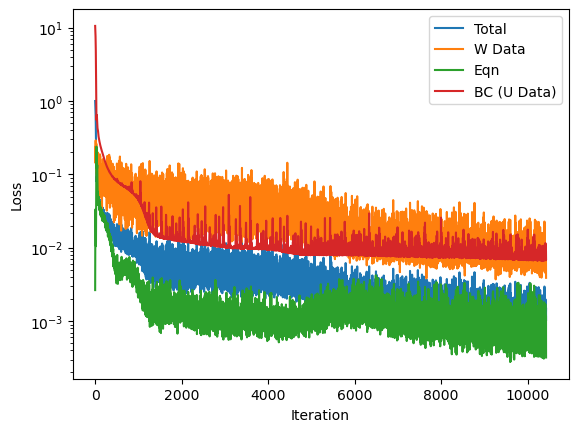

In [10]:
def plot_loss(loss):
  np_loss = np.array(loss)
  plt.semilogy(np_loss[:,0],label='Total')
  plt.semilogy(np_loss[:,1],label='W Data')
  plt.semilogy(np_loss[:,2],label='Eqn')
  plt.semilogy(np_loss[:,3],label='BC (U Data)')
  plt.legend()
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
plot_loss(loss1)

In [11]:
# set the training iteration
epoch2 = 10000
# re-sample the data and collocation points
data_l = dataf_l(key_lbfgs[1])

# training with L-bfgs
trained_params2, loss2 = lbfgs_optimizer(NN_loss, trained_params, data_l, epoch2)


Step: NaN | Loss: 1.3210e-03 | Loss_d: 6.6896e-03 Loss_e: 5.5789e-04 | Loss_b: 6.9949e-03
Step: NaN | Loss: 3.1748e-01 | Loss_d: 2.6645e-02 Loss_e: 2.0358e-01 | Loss_b: 3.1928e+00
Step: NaN | Loss: 1.3004e-03 | Loss_d: 6.6422e-03 Loss_e: 5.7837e-04 | Loss_b: 6.8005e-03
Step: NaN | Loss: 1.2940e-03 | Loss_d: 6.5977e-03 Loss_e: 5.6153e-04 | Loss_b: 6.7925e-03
Step: NaN | Loss: 1.3346e-03 | Loss_d: 6.4398e-03 Loss_e: 5.3378e-04 | Loss_b: 7.4156e-03
Step: NaN | Loss: 1.2932e-03 | Loss_d: 6.5773e-03 Loss_e: 5.5491e-04 | Loss_b: 6.8112e-03
Step: NaN | Loss: 1.2874e-03 | Loss_d: 6.5602e-03 Loss_e: 5.8003e-04 | Loss_b: 6.7403e-03
Step: NaN | Loss: 1.2874e-03 | Loss_d: 6.5610e-03 Loss_e: 5.7864e-04 | Loss_b: 6.7406e-03
Step: NaN | Loss: 1.2795e-03 | Loss_d: 6.5438e-03 Loss_e: 5.5365e-04 | Loss_b: 6.6977e-03
Step: NaN | Loss: 1.2647e-03 | Loss_d: 6.4987e-03 Loss_e: 5.0136e-04 | Loss_b: 6.6361e-03
Step: NaN | Loss: 1.6045e-03 | Loss_d: 6.8495e-03 Loss_e: 1.3396e-03 | Loss_b: 9.1110e-03
Step: NaN 

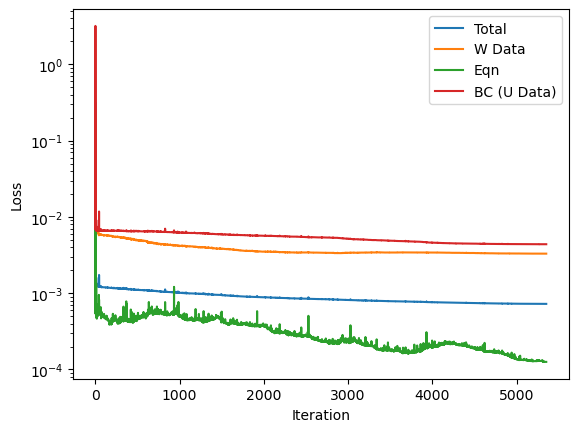

In [12]:
plot_loss(loss2)

In [13]:
# now lets make a prediction - this cell likely does not need to be changed
from equations.gradients import *
f_u = lambda x: pred_u(trained_params2, x)
f_gu = lambda x: vectgrad(f_u, x)[0][:, 0:10]
f_eqn = lambda x: gov_eqn(f_u, x, info)

x_pred = df_norm[['x','z']].values
uw_rho_pmu = f_u(x_pred)
# set the partition number
nsp = 4
# separate input into different partition to avoid GPU memory limit
x_psp = jnp.array_split(x_pred, nsp)
idxsp = jnp.arange(nsp).tolist()
# calculate the derivative of network output at the velocity-data positions
du_list = tree_map(lambda x: f_gu(x_psp[x]), idxsp)
# calculate the associated equation residue of the trained network
eqnterm_list = tree_map(lambda x: f_eqn(x_psp[x]), idxsp)
eqn_list = tree_map(lambda x: eqnterm_list[x][0], idxsp)
term_list = tree_map(lambda x: eqnterm_list[x][1], idxsp)
# combine the sub-group list into a long array
duw_rho_pmu = jnp.vstack(du_list)
eqn = jnp.vstack(eqn_list)
term = jnp.vstack(term_list)
results = {}
for i,key in enumerate(['u','w','rho','p','mu']):
    results[f'{key}_g'] = df_full[key].values
    results[f'{key}_p'] = uw_rho_pmu[:,i:i+1]*info[f'{key}_range'] + info[f'{key}_mean']
    results[f'{key}x_p'] = duw_rho_pmu[:,2*i:2*i+1] * info[f'{key}_range']/info['x_range']
    results[f'{key}z_p'] = duw_rho_pmu[:,2*i+1:2*i+2] * info[f'{key}_range']/info['z_range']
    
results['x'] = df_full['x'].values
results['z'] = df_full['z'].values

In [14]:
# predicting equation terms is unique to each model
term0 = info['rho_range']*info['w_range']/info['z_range']
results['e0']=eqn[:, 0:1] * term0
results['e01']=term[:, 0:1] * term0
results['e02']=term[:, 1:2] * term0

Text(0, 0.5, 'Inversion results')

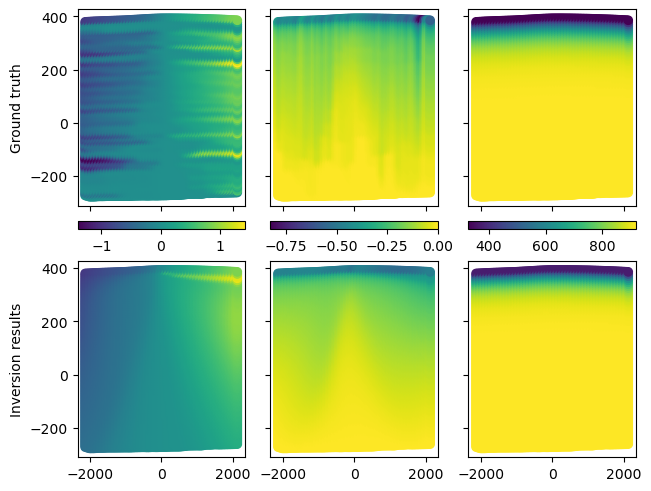

In [15]:
fig, axs = plt.subplots(nrows=2,ncols=3,layout='constrained',sharex=True,sharey=True)
for i,key in enumerate(['u','w','rho']):
    c = axs[0,i].scatter(results['x'],results['z'],c=results[f'{key}_g'])
    fig.colorbar(c, ax=axs[0, i], location='bottom')
    new_c = axs[1, i].scatter(results['x'], results['z'], 
                          c=results[f'{key}_p'], 
                          cmap=c.cmap, norm=c.norm)
axs[0][0].set_ylabel('Ground truth')
axs[1][0].set_ylabel('Inversion results')

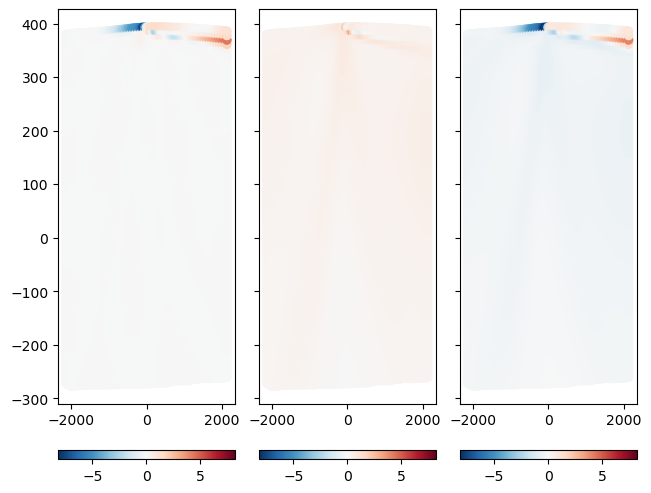

In [16]:
# check equation physics
fig, axs = plt.subplots(ncols=3,layout='constrained',sharex=True,sharey=True)
vmax = np.max(np.abs([results['e0'],results['e01'],results['e02']]))
for i, key in enumerate(['e0','e01','e02']):
    c = axs[i].scatter(results['x'],results['z'],c=results[key],vmin=-vmax,vmax=vmax,cmap='RdBu_r')
    fig.colorbar(c, ax=axs[i], location='bottom')

In [17]:
# now use u,w, rho predicted as ground truth for momentum
dict_full = {}
dict_surf = {}
dict_flanks = {}
dict_bed = {}
dict_divide = {}
# calculate mu
du_dx = np.gradient(results['u_p'].reshape(x.shape), axis=0)/np.gradient(x, axis=0)
dw_dz = np.gradient(results['w_p'].reshape(x.shape), axis=1)/np.gradient(z, axis=1)
du_dz = np.gradient(results['u_p'].reshape(x.shape), axis=1)/np.gradient(z, axis=1)
dw_dx = np.gradient(results['w_p'].reshape(x.shape),axis=0)/np.gradient(x, axis=0)

# Compute strain rate components
strain_xx = du_dx
strain_zz = dw_dz
strain_xz = 0.5 * (du_dz + dw_dx)

# Compute effective strain rate
strain_eff = np.sqrt(0.5 * (strain_xx**2 + strain_zz**2 + 2 * strain_xz**2))

# Compute effective viscosity
A = 1e-24  # Flow law parameter in Pa^-3 s^-1
n = 3  # Glen's law exponent
mu = (1 / 2) * A**(-1/n) * strain_eff**((1-n)/n)


for key in ['x','z','u','w','rho','p','mu']:
    if key in ['x','z']:
        var = results[key].reshape(x.shape)
    elif key in ['u','w','rho']:
        var = results[f'{key}_p'].reshape(x.shape)
    elif key == 'p':
        var = p
    elif key == 'mu':
        var = mu
    dict_full[key]=var.flatten()
    dict_surf[key]=var[:,-1]
    dict_bed[key] = var[:,0]
    dict_flanks[key] =np.array([var[0,:].flatten(),var[-1,:].flatten()]).flatten()
    div_bed = np.interp(0,x[:,0],var[:,0])
    vardiv_surf = np.interp(0,x[:,-1],var[:,-1])
    div = np.linspace(div_bed,vardiv_surf,100).reshape((100,1))
    dict_divide[key] = div.flatten()
dict_divide['u'] = np.zeros(dict_divide['x'].shape)

df_full = pd.DataFrame(dict_full)
df_surf = pd.DataFrame(dict_surf)
df_bed = pd.DataFrame(dict_bed)
df_flanks = pd.DataFrame(dict_flanks)
df_divide = pd.DataFrame(dict_divide)

In [18]:
from equations.momentum_conservation import gov_eqn as gov_eqn_momentum


In [33]:
# generate PINN
# select a random seed
seed = 1234 #2134
key = random.PRNGKey(seed)
np.random.seed(seed)

# create the subkeys
keys = random.split(key, 4) # NEED TO UPDATE 4 to relevant number
n_hl = 6
n_unit = 30
# initialize the weights and biases of the network
trained_params = init_pinns(keys[0], n_hl, n_unit)

In [34]:
# normalize
df_norm,df_bcs,info = normalize(df_full, df_surf, df_divide, df_bed, df_flanks)
# df_bcs contains the data for surface, divide,bed and flanks

In [35]:
pred_u = create_solution(df_bcs[0]) # need to modify as well


In [36]:
# for adam
n_samples = jnp.array([200,200]) # small number for now
dataf = sample(df_norm,n_samples,df_bcs) # nsamples is for data loss + colocation points
keys_adam = random.split(keys[1], 5)
data = dataf(keys_adam[0])

# for L-BFGS
n_pt2 = n_samples * 2
dataf_l = sample(df_norm, n_pt2,df_bcs)
key_lbfgs = random.split(keys[2], 5)

In [37]:
def ms_error(diff):
    return jnp.mean(jnp.square(diff), axis=0)

def create_loss_momentum(predf,gov_eqn,scales,lw):
    # for now do 3 lw weights: data, eqn, bc
    def loss_fun(params, data):
        # create the function for gradient calculation involves input Z only
        net = lambda z: predf(params, z)
        
        # load the ground truth for dataloss
        x_smp = data['smp'][0]
        U_smp = data['smp'][1][:,0:3] # ground truth u,w,rho
        # assuming only surface ice pressure is known
        x_surf = data['surf'][0]
        p_surf = data['surf'][1][:,3:4] # ground truth surface ice pressure
        
        # assuming known viscosities at flanks
        x_flanks = data['flanks'][0]
        mu_flanks = data['flanks'][1][:,3:5] # doing pressures and viscosities at flank

        # load the position and weight of collocation points
        x_col = data['col'][0]

        # calculate the predicted variables
        U_pred = net(x_smp)[:, 0:3] # predicting u, w, rho

        # boundary constraints
        p_surf_pred = net(x_surf)[:,3:4]
        mu_flanks_pred = net(x_flanks)[:,3:5]
        
        # calculate the residue of equation
        f_pred,terms = gov_eqn(net, x_col, scales)

        # calculate the mean squared root error of data
        data_err = ms_error(U_pred - U_smp)

        # calculate the mean squared root error of equation
        eqn_err = ms_error(f_pred)

        # calculate errors of boundary conditions
        surf_err = ms_error(p_surf-p_surf_pred)
        flanks_err = ms_error(mu_flanks-mu_flanks_pred)

        # all errors should be 1d arrays
        # calculate the overall data loss and equation loss
        loss_data = jnp.sum(data_err)
        loss_eqn = jnp.sum(eqn_err)
        loss_bd = jnp.sum(flanks_err) + jnp.sum(surf_err)

        loss_ref = loss_fun.lref
        # calculate total loss

        # lw should have 3 weights
        loss = (lw[0]*loss_data + lw[1]*loss_eqn + lw[2]*loss_bd ) / loss_ref
        
        # group the loss of all conditions and equations
        loss_info = jnp.hstack([jnp.array([loss, loss_data, loss_eqn, loss_bd]),
                                data_err, eqn_err, flanks_err,surf_err])
        return loss, loss_info

    loss_fun.lref = 1.0
    return loss_fun

In [38]:
# create the loss function
NN_loss = create_loss_momentum(pred_u, gov_eqn, info, [1,1,1])
# calculate the initial loss and set it as the reference value for loss
NN_loss.lref = NN_loss(trained_params, data)[0]

In [39]:
# set the learning rate for Adam
lr = 1e-3
# set the training iteration
epoch1 = 10000

# training with Adam
trained_params, loss1 = adam_optimizer(keys_adam[1], NN_loss, trained_params, dataf, epoch1, lr=lr)


Step: 100 | Loss: 6.5140e-02 | Loss_d: 5.0764e-01 | Loss_e: 1.9811e-02 | Loss_b: 3.6384e-02
Step: 200 | Loss: 5.0576e-02 | Loss_d: 3.9983e-01 | Loss_e: 7.6233e-03 | Loss_b: 3.0320e-02
Step: 300 | Loss: 2.3448e-02 | Loss_d: 1.7186e-01 | Loss_e: 4.8080e-03 | Loss_b: 2.6297e-02
Step: 400 | Loss: 2.4251e-02 | Loss_d: 1.8057e-01 | Loss_e: 5.3750e-03 | Loss_b: 2.3969e-02
Step: 500 | Loss: 2.3243e-02 | Loss_d: 1.7657e-01 | Loss_e: 3.0691e-03 | Loss_b: 2.1544e-02
Step: 600 | Loss: 1.4087e-02 | Loss_d: 9.9809e-02 | Loss_e: 2.9772e-03 | Loss_b: 1.9143e-02
Step: 700 | Loss: 1.5853e-02 | Loss_d: 1.2140e-01 | Loss_e: 1.6404e-03 | Loss_b: 1.4174e-02
Step: 800 | Loss: 1.6498e-02 | Loss_d: 1.3015e-01 | Loss_e: 3.6400e-03 | Loss_b: 9.0098e-03
Step: 900 | Loss: 1.7445e-02 | Loss_d: 1.4372e-01 | Loss_e: 3.9204e-03 | Loss_b: 3.3542e-03
Step: 1000 | Loss: 1.5159e-02 | Loss_d: 1.2618e-01 | Loss_e: 2.9279e-03 | Loss_b: 2.1092e-03
Step: 1100 | Loss: 1.4579e-02 | Loss_d: 1.1844e-01 | Loss_e: 6.0653e-03 | Loss_

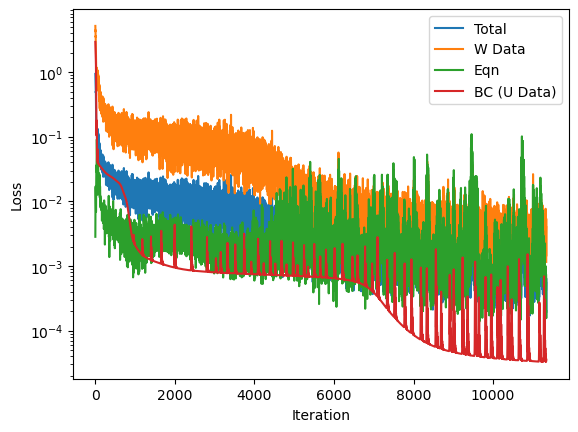

In [40]:
def plot_loss(loss):
  np_loss = np.array(loss)
  plt.semilogy(np_loss[:,0],label='Total')
  plt.semilogy(np_loss[:,1],label='W Data')
  plt.semilogy(np_loss[:,2],label='Eqn')
  plt.semilogy(np_loss[:,3],label='BC (U Data)')
  plt.legend()
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
plot_loss(loss1)

In [41]:
# set the training iteration
epoch2 = 10000
# re-sample the data and collocation points
data_l = dataf_l(key_lbfgs[1])

# training with L-bfgs
trained_params2, loss2 = lbfgs_optimizer(NN_loss, trained_params, data_l, epoch2)


Step: NaN | Loss: 3.5766e-04 | Loss_d: 2.5965e-03 Loss_e: 4.6399e-04 | Loss_b: 3.5378e-05
Step: NaN | Loss: 5.3024e-02 | Loss_d: 1.2067e-01 Loss_e: 3.3819e-01 | Loss_b: 1.0146e-04
Step: NaN | Loss: 1.1524e-03 | Loss_d: 5.3500e-03 Loss_e: 4.5909e-03 | Loss_b: 3.3633e-05
Step: NaN | Loss: 3.4367e-04 | Loss_d: 2.6839e-03 Loss_e: 2.5578e-04 | Loss_b: 3.5091e-05
Step: NaN | Loss: 3.4031e-04 | Loss_d: 2.6526e-03 Loss_e: 2.5813e-04 | Loss_b: 3.4897e-05
Step: NaN | Loss: 3.3657e-04 | Loss_d: 2.5690e-03 Loss_e: 3.1010e-04 | Loss_b: 3.4217e-05
Step: NaN | Loss: 3.3602e-04 | Loss_d: 2.5849e-03 Loss_e: 2.8921e-04 | Loss_b: 3.4385e-05
Step: NaN | Loss: 3.3141e-04 | Loss_d: 2.5866e-03 Loss_e: 2.4808e-04 | Loss_b: 3.3929e-05
Step: NaN | Loss: 3.4008e-04 | Loss_d: 2.6901e-03 Loss_e: 2.2056e-04 | Loss_b: 3.3004e-05
Step: NaN | Loss: 3.2947e-04 | Loss_d: 2.6015e-03 Loss_e: 2.1682e-04 | Loss_b: 3.3500e-05
Step: NaN | Loss: 3.2716e-04 | Loss_d: 2.5879e-03 Loss_e: 2.1063e-04 | Loss_b: 3.3277e-05
Step: NaN 

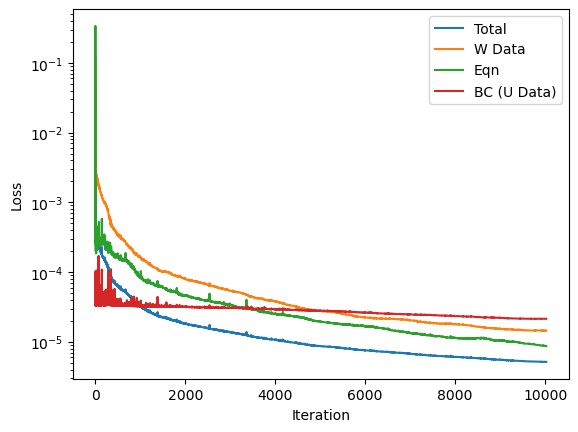

In [42]:
plot_loss(loss2)

In [43]:
# now lets make a prediction - this cell likely does not need to be changed
from equations.gradients import *
f_u = lambda x: pred_u(trained_params2, x)
f_gu = lambda x: vectgrad(f_u, x)[0][:, 0:10]
f_eqn = lambda x: gov_eqn_momentum(f_u, x, info)

x_pred = df_norm[['x','z']].values
uw_rho_pmu = f_u(x_pred)
# set the partition number
nsp = 4
# separate input into different partition to avoid GPU memory limit
x_psp = jnp.array_split(x_pred, nsp)
idxsp = jnp.arange(nsp).tolist()
# calculate the derivative of network output at the velocity-data positions
du_list = tree_map(lambda x: f_gu(x_psp[x]), idxsp)
# calculate the associated equation residue of the trained network
eqnterm_list = tree_map(lambda x: f_eqn(x_psp[x]), idxsp)
eqn_list = tree_map(lambda x: eqnterm_list[x][0], idxsp)
term_list = tree_map(lambda x: eqnterm_list[x][1], idxsp)
# combine the sub-group list into a long array
duw_rho_pmu = jnp.vstack(du_list)
eqn = jnp.vstack(eqn_list)
term = jnp.vstack(term_list)
results = {}
for i,key in enumerate(['u','w','rho','p','mu']):
    results[f'{key}_g'] = df_full[key].values
    results[f'{key}_p'] = uw_rho_pmu[:,i:i+1]*info[f'{key}_range'] + info[f'{key}_mean']
    results[f'{key}x_p'] = duw_rho_pmu[:,2*i:2*i+1] * info[f'{key}_range']/info['x_range']
    results[f'{key}z_p'] = duw_rho_pmu[:,2*i+1:2*i+2] * info[f'{key}_range']/info['z_range']
    
results['x'] = df_full['x'].values
results['z'] = df_full['z'].values

# temporary fix for pressures being in MPa
results['p_p'] = results['p_p']/1e6

In [44]:
# predicting equation terms is unique to each model
term0 = info['rho_range']*9.81*info['z_range']/info['x_range']
results['e1']=eqn[:, 0:1] * term0
results['e11']=term[:, 0:1] * term0
results['e12']=term[:, 1:2] * term0
results['e13']=term[:, 2:3] * term0

term1 = info['rho_range']*9.81
results['e2']=eqn[:, 1:2] * term1
results['e21']=term[:, 3:4] * term1
results['e22']=term[:, 4:5] * term1
results['e23']=term[:, 5:6] * term1

Text(0, 0.5, 'Inversion results')

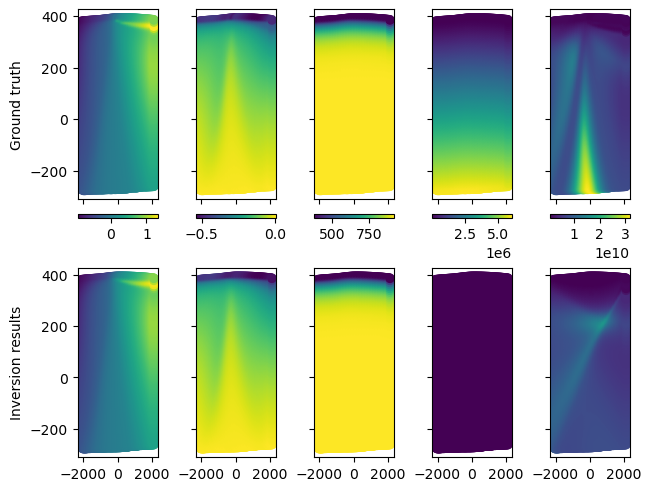

In [45]:
fig, axs = plt.subplots(nrows=2,ncols=5,layout='constrained',sharex=True,sharey=True)
for i,key in enumerate(['u','w','rho','p','mu']):
    c = axs[0,i].scatter(results['x'],results['z'],c=results[f'{key}_g'])
    fig.colorbar(c, ax=axs[0, i], location='bottom')
    new_c = axs[1, i].scatter(results['x'], results['z'], 
                          c=results[f'{key}_p'], 
                          cmap=c.cmap, norm=c.norm)
axs[0][0].set_ylabel('Ground truth')
axs[1][0].set_ylabel('Inversion results')

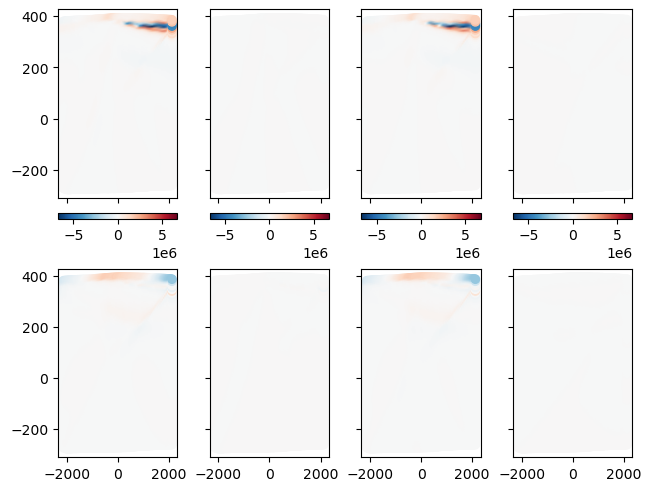

In [46]:
# check equation physics
fig, axs = plt.subplots(ncols=4,nrows=2,layout='constrained',sharex=True,sharey=True)
vmax = np.max(np.abs([results['e1'],results['e11'],results['e12'],results['e13'],
                     results['e2'],results['e21'],results['e22'],results['e23']]))

c=axs[0,0].scatter(results['x'],results['z'],c=results['e1'],vmin=-vmax,vmax=vmax,cmap='RdBu_r')
fig.colorbar(c, ax=axs[0,0], location='bottom')
axs[1,0].scatter(results['x'],results['z'],c=results['e2'],vmin=-vmax,vmax=vmax,cmap='RdBu_r')

for i in range(3):
    c = axs[0,i+1].scatter(results['x'],results['z'],c=results[f'e1{i+1}'],vmin=-vmax,vmax=vmax,cmap='RdBu_r')
    fig.colorbar(c, ax=axs[0,i+1], location='bottom')
    axs[1,i+1].scatter(results['x'],results['z'],c=results[f'e2{i+1}'],vmin=-vmax,vmax=vmax,cmap='RdBu_r')